# BI-PRS - Semestral work 3

In [100]:
# Dataset selection according to the represant's data
K <- 27
L <- nchar('bardatskii')
M <- ((K + L) * 47) %% 11 + 1

cat('Parameter M =', M, '=> Kamil Dedecius')
cat('\nYear =', 2011 + M)

Parameter M = 2 => Kamil Dedecius
Year = 2013

In [101]:
# TODO: lexicographical order

# Neccessary imports
library(eurostat)
library(car)
library(tseries)
library(lmtest)
library(countrycode)
library(stringr)
library(ggplot2)
library(psych)
library(corrplot)

## Abstract

The project examines the [**Gross Domestic Product (GDP)**](https://www.investopedia.com/terms/g/gdp.asp) of **European countries** in **2013**. The study investigates [**nominal GDP per capita**](https://www.investopedia.com/terms/n/nominalgdp.asp) in particular.

**Table of contents:**
- Dataset preparation
- GDP elucidation
- Regressors selection
- Dependencies visualization
- Statistical tests
- .

### Data preparation

In [102]:
# Load the dataset
data <- get_eurostat(id='nama_10_pc')
head(data, 5)

Dataset query already saved in cache_list.json...

Reading cache file /tmp/RtmprxgH87/eurostat/fc1b73118a442712eb0be205edcfad10.rds

Table  nama_10_pc  read from cache file:  /tmp/RtmprxgH87/eurostat/fc1b73118a442712eb0be205edcfad10.rds



freq,unit,na_item,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
A,CLV10_EUR_HAB,B1GQ,AL,1995-01-01,1310
A,CLV10_EUR_HAB,B1GQ,AL,1996-01-01,1410
A,CLV10_EUR_HAB,B1GQ,AL,1997-01-01,1270
A,CLV10_EUR_HAB,B1GQ,AL,1998-01-01,1390
A,CLV10_EUR_HAB,B1GQ,AL,1999-01-01,1580


Transform the dataset, leaving only **Gross Domestic Product per capita** in euros in **2013** for individual European countries.

In [103]:
colnames(data)[4] <- 'country'  # rename "geo" column
colnames(data)[6] <- 'GDPpc'    # rename "values" column
data <- subset(data,
               na_item == 'B1GQ' &     # Gross domestic product at market prices
               unit == 'CP_EUR_HAB' &  # Current prices, euro per capita
               TIME_PERIOD == '2013-01-01' &
               !(country %in% c(
                   'EU27_2020',  # European Union - 27 countries (from 2020)
                   'EU28',       # European Union - 28 countries (2013-2020)
                   'EU15',       # European Union - 15 countries (1995-2004)
                   'EA',         # Euro area
                   'EA20',       # Euro area – 20 countries (from 2023)
                   'EA19',       # Euro area - 19 countries  (2015-2022)
                   'EA12'        # Euro area - 12 countries (2001-2006)
               )),
               c(country, GDPpc))
data$country <- countrycode(data$country, 'eurostat', 'country.name')
data$country <- factor(data$country)
head(data, 3)

country,GDPpc
<fct>,<dbl>
Albania,3320
Austria,38210
Belgium,35210


In [104]:
any(is.na(data$GDPpc)) # Check for NA values

[1] FALSE

## GDP elucidation

Analyze the `GDPpc` using statistical metrics and visualizations.

In [105]:
describe(data$GDPpc, ranges=F, quant=c(0.25, 0.5, 0.75), IQR=T)[, -1]

,n,mean,sd,skew,kurtosis,se,IQR,Q0.25,Q0.5,Q0.75
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,37,28581.89,26472.6,1.872638,3.834095,4352.069,27700,10480,18680,38180


Skewness and the strong deviation of the mean from the median indicate the presence of an *“eastern”* tail in the distribution. Let's check it out on the histogram.

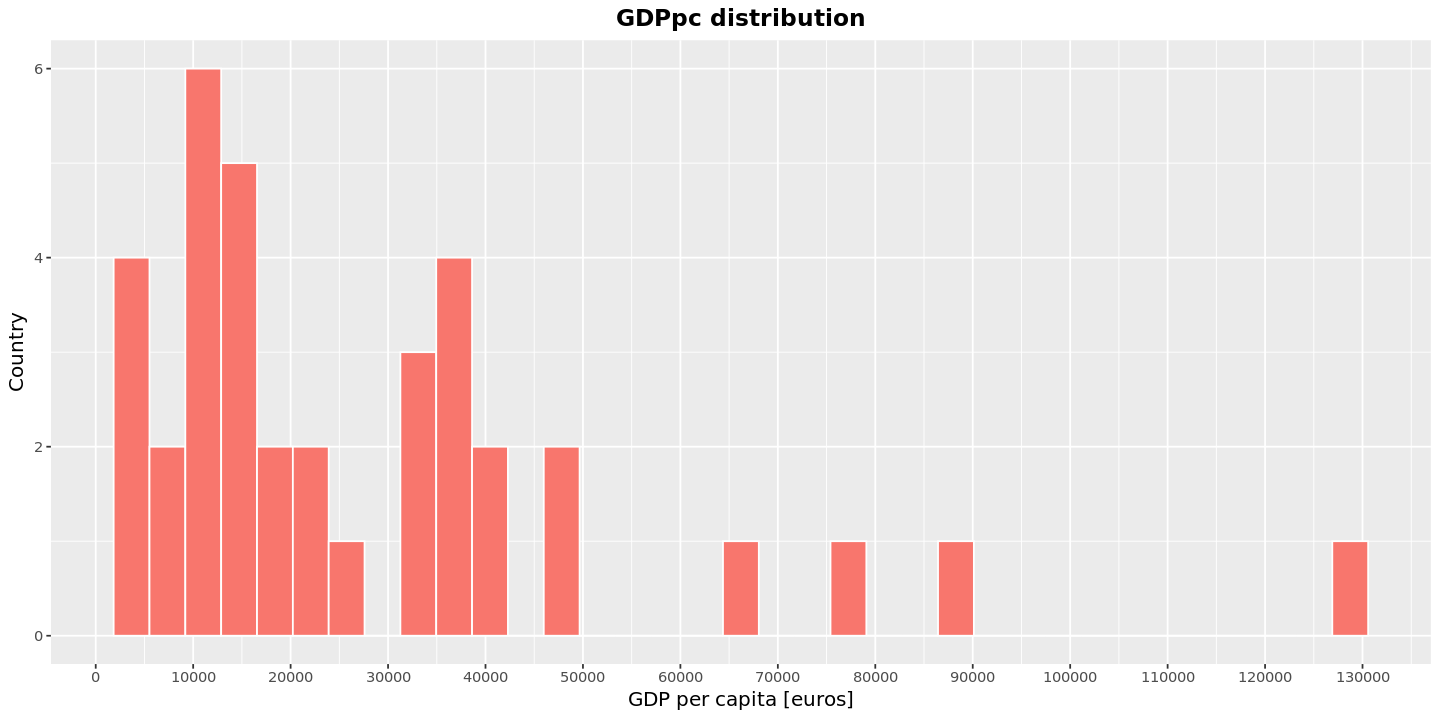

In [106]:
options(repr.plot.width=12, repr.plot.height=6)                        # figure settings 

ggplot(data, aes(x=GDPpc)) +                                           
  geom_histogram(bins=35, fill='#f8766d', col='white') +               # hist
  labs(title='GDPpc distribution',                                     # labels        
       x='GDP per capita [euros]',
       y='Country') + 
  scale_x_continuous(breaks=scales::pretty_breaks(n=12)) +             # set x axis ticks
  theme(
    plot.title = element_text(hjust = 0.5, size=14, face="bold"),      # center and style the title
    axis.title = element_text(size=12),                                # axis title size
  )

As expected, the distribution has a tail. Several countries have a much higher `GDPpc` than the rest.

In addition, three potential clusters can be noticed in the graph: 

1. $\mathrm{GDPpc} \le 30000$,
2. $30000 < \mathrm{GDPpc} \le 60000$,
3. $60000 < \mathrm{GDPpc}$.

Each of these clusters may be amenable to its own distribution.

## Regressors selection

[Many factors](https://www.investopedia.com/articles/investing/051415/how-calculate-gdp-country.asp) can affect the GDP per capita and a country's economy. Below we offer three variants of a continuous variable and one binary. [Human Development Report](https://en.wikipedia.org/wiki/Human_Development_Report) will be a data source for regressors. [(link)](https://hdr.undp.org/data-center/documentation-and-downloads)

### Continuous regressors



In [107]:
# Load the dataset
extra_src_url <- 'https://hdr.undp.org/sites/default/files/2023-24_HDR/HDR23-24_Composite_indices_complete_time_series.csv'

In [108]:
extra_data <- read.csv(url(extra_src_url), encoding='UTF-8')
extra_data$country <- str_replace(extra_data$country, 'T\xfcrkiye', 'Turkey')
head(extra_data, 5)

,iso3,country,hdicode,region,hdi_rank_2022,hdi_1990,hdi_1991,hdi_1992,hdi_1993,hdi_1994,⋯,pop_total_2013,pop_total_2014,pop_total_2015,pop_total_2016,pop_total_2017,pop_total_2018,pop_total_2019,pop_total_2020,pop_total_2021,pop_total_2022
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AFG,Afghanistan,Low,SA,182,0.284,0.292,0.299,0.307,0.300,⋯,31.5412085,32.7162100,33.7534990,34.6362075,35.6434175,36.6867840,37.769498,38.972231,40.099462,41.128771
2,ALB,Albania,High,ECA,74,0.649,0.632,0.616,0.618,0.623,⋯,2.8870140,2.8841020,2.8824805,2.8810630,2.8793550,2.8770130,2.873883,2.866849,2.854710,2.842321
3,DZA,Algeria,High,AS,93,0.593,0.596,0.601,0.602,0.603,⋯,38.0006265,38.7601675,39.5431545,40.3393285,41.1365460,41.9270070,42.705368,43.451666,44.177968,44.903225
4,AND,Andorra,Very High,,35,NA,NA,NA,NA,NA,⋯,0.0713665,0.0716215,0.0717455,0.0725405,0.0738365,0.0750135,0.076343,0.077700,0.079034,0.079824
5,AGO,Angola,Medium,SSA,150,NA,NA,NA,NA,NA,⋯,26.1470020,27.1283365,28.1277210,29.1547455,30.2086280,31.2735330,32.353588,33.428486,34.503774,35.588987


In [109]:
# Check if the additional dataset has all countries required
all(data$country %in% extra_data$country)

[1] TRUE

Only some features are needed, which are:
- `LE`: Life Expectancy at Birth (years)
- `MYS`: Mean Years of Schooling (years)
- `EYS`: Expected Years of Schooling (years)
- `GNIpc`: Gross National Income Per Capita (2017 PPP$)
*all for 2013

In [110]:
extra_data <- subset(extra_data,
       country %in% data$country,
       c(
           'country',
           'le_2013',  # Life Expectancy at Birth [years] ~ LE
           'mys_2013',  # Mean Years of Schooling [years] ~ MYS
           'eys_2013',  # Expected Years of Schooling [years] ~ EYS
           'gnipc_2013'  # Gross National Income Per Capita [2017 PPP$] ~ GNIpc
       ))

In [111]:
any(is.na(extra_data)) # Check for NA values

[1] FALSE

In [112]:
data <- merge(data, extra_data, by='country') # Merge the datasets

The indicators in one way or another related to the [Human Development Index](https://en.wikipedia.org/wiki/Human_Development_Index) were taken as a basis.

First of all, let's look at how HDI is calculated:

1. **Life Expectancy Index**: $\mathrm{LEI} = \frac{\mathrm{LE} - 20}{65}$
2. **Education Index**: $\mathrm{EI} = \frac{\frac{\mathrm{MYS}}{15} + \frac{\mathrm{EYS}}{18}}{2}$
3. **Income Index**: $\mathrm{II} = \frac{\ln(\mathrm{GNIpc}) - \ln(100)}{\ln(750)}$
4. **Human Development Index**: $\mathrm{HDI} = \sqrt[3]{\mathrm{LEI} \cdot \mathrm{EI} \cdot \mathrm{II}}$

Instead of using HDI itself, we take its components. However, just taking the presented indexes is not a good idea. Let's see why.

The problem with using LEI is that its values are much more difficult to interpret than LE values. As a consequence, we leave LE untouched.

GNIpc is calculated using the following formula$$\mathrm{GNIpc} = \mathrm{GDPpc} + \mathrm{NFIApc},$$where NFIApc is **Net Income from Abroad per capita** and is calculated as$$\mathrm{NFIApc} = \frac{\text{Money flowing from foreign countries} - \text{Money flowing to foreign countries}}{\text{Population}}.$$

Since GNIpc already contains GDPpc, using it would mean that our model would implicitly learn to predict NFIApc. This is not quite the right approach to the problem at hand. Therefore, we only take NFIApc as a regressor. However, we cannot simply subtract euro GDPpc from dollar GNIpc, we need to convert GNIpc into euros beforehand. For this purpose we use [this](https://www.exchangerates.org.uk/EUR-USD-spot-exchange-rates-history-2013.html#:~:text=Average%20exchange%20rate%20in%202013%3A%201.3284%20USD.) exchange rate.

In [113]:
data$LE <- data$le_2013
data$EI <- (data$mys_2013 / 15 + data$eys_2013 / 18) / 2
data$NFIApc <- data$gnipc_2013 / 1.3284 - data$GDPpc
data <- data[, c('country', 'GDPpc', 'LE', 'EI', 'NFIApc')]
head(data, 5)

,country,GDPpc,LE,EI,NFIApc
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,Albania,3320,78.123,0.7781896,5376.903
2,Austria,38210,81.078,0.8383914,1791.626
3,Belgium,35210,80.468,0.9221770,1962.076
4,Bulgaria,5790,74.849,0.7824033,8144.946
5,Croatia,10480,77.843,0.8044435,7332.921


#### Binary factor

The factor of the country's entry into the [Blue Banana](https://en.wikipedia.org/wiki/Blue_Banana) area was chosen as a binary predictor. The intuition behind this decision is based on the fact that the cities within this zone are of great economic importance.

Here's a [**link**](https://en.wikipedia.org/wiki/Blue_Banana) to the data source.

In [114]:
data$BB_entry <- (data$country %in% c(
    'Austria',
    'Belgium',
    'France',
    'Germany',
    'Italy',
    'Luxembourg',
    'Netherlands',
    'United Kingdom',
    'Liechtenstein',
    'Switzerland'
))

head(data, 5)

,country,GDPpc,LE,EI,NFIApc,BB_entry
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,Albania,3320,78.123,0.7781896,5376.903,FALSE
2,Austria,38210,81.078,0.8383914,1791.626,TRUE
3,Belgium,35210,80.468,0.9221770,1962.076,TRUE
4,Bulgaria,5790,74.849,0.7824033,8144.946,FALSE
5,Croatia,10480,77.843,0.8044435,7332.921,FALSE


## Data Visualization

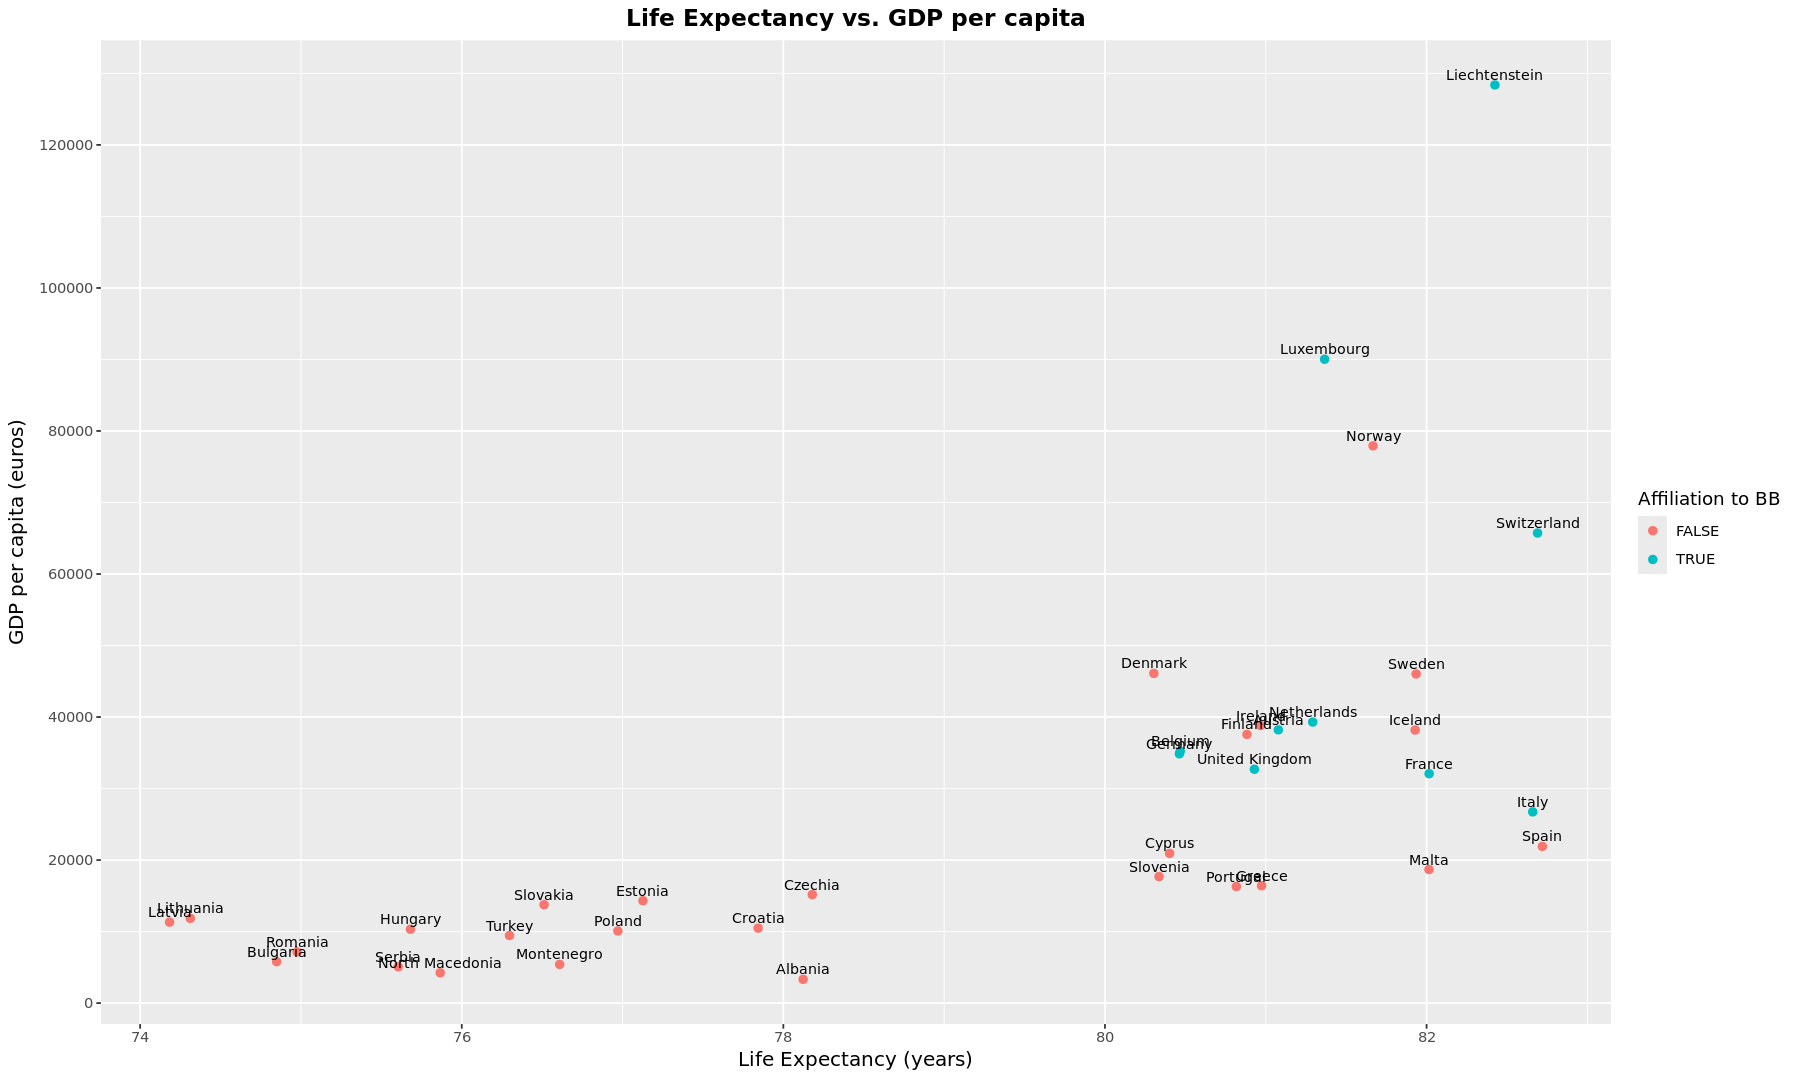

In [115]:
options(repr.plot.width=15, repr.plot.height=9)                        # figure settings 

ggplot(data, aes(x=LE, y=GDPpc)) +
  geom_point(aes(col=BB_entry), size=2) +                              
  geom_text(aes(label=country), size=3, vjust=-0.5, hjust=0.5) +       
  labs(title='Life Expectancy vs. GDP per capita',                     # labels
       x='Life Expectancy (years)',
       y='GDP per capita (euros)',
       color='Affiliation to BB') + 
  scale_y_continuous(breaks=scales::pretty_breaks(n=5)) +             # set y axis ticks
  theme(
    plot.title = element_text(hjust = 0.5, size=14, face="bold"),      # center and style the title
    axis.title = element_text(size=12),                                # axis title size
  )

- The plot helps visualize economic disparities and their potential impact on life expectancy across different countries.
- There is a visible trend where countries with higher GDP per capita and affiliation to BB generally have higher life expectancies.

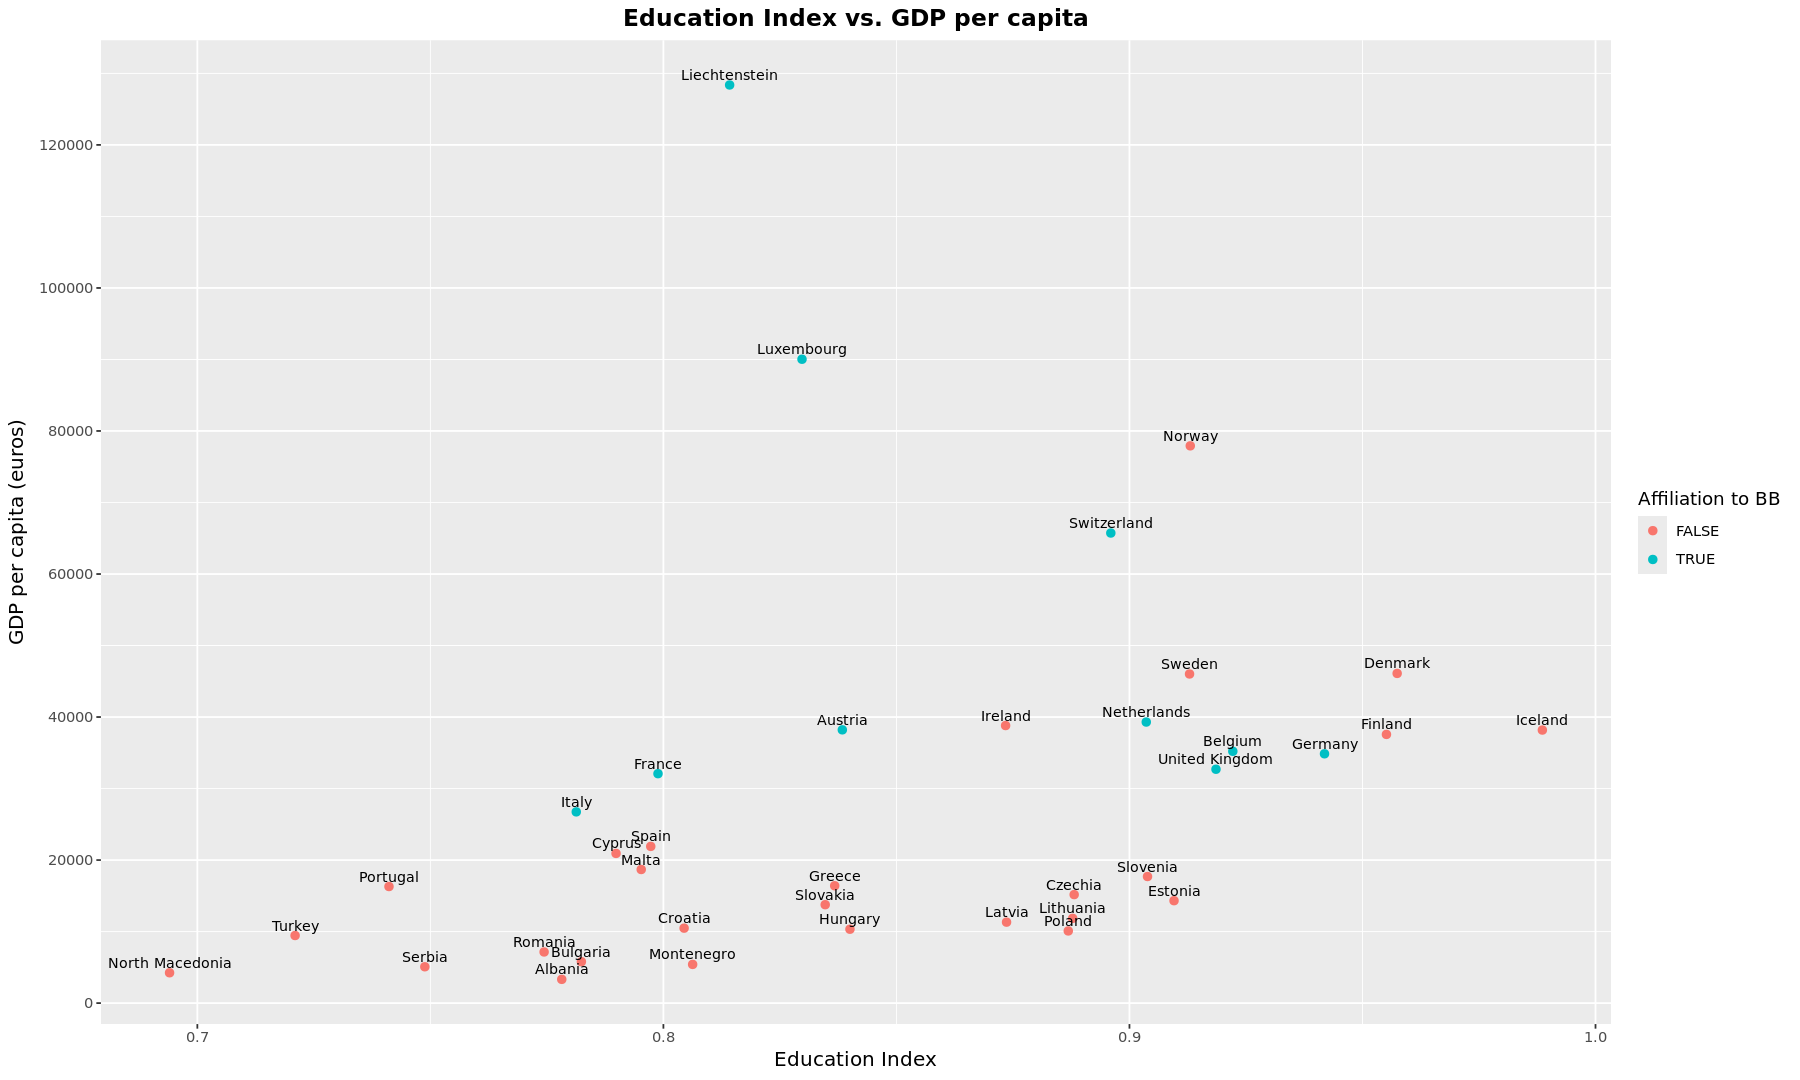

In [116]:
options(repr.plot.width=15, repr.plot.height=9)                        # figure settings 

ggplot(data, aes(x=EI, y=GDPpc)) +
  geom_point(aes(col=BB_entry), size=2) +
  geom_text(aes(label=country), size=3, vjust=-0.5, hjust=0.5) +  
  labs(title='Education Index vs. GDP per capita',                     # labels
       x='Education Index',
       y='GDP per capita (euros)',
       color='Affiliation to BB') + 
  scale_y_continuous(breaks=scales::pretty_breaks(n=5)) +            # set y axis ticks
  theme(
    plot.title = element_text(hjust = 0.5, size=14, face="bold"),      # center and style the title
    axis.title = element_text(size=12),                                # axis title size
  )

- There is a general trend showing that countries with higher Education Index scores tend to have higher GDP per capita.
- Outliers like Liechtenstein and Luxembourg have exceptionally high GDP per capita compared to their Education Index.
- Countries with lower Education Index scores (around 0.7 to 0.8) generally have lower GDP per capita, such as North Macedonia, Turkey, and Serbia.

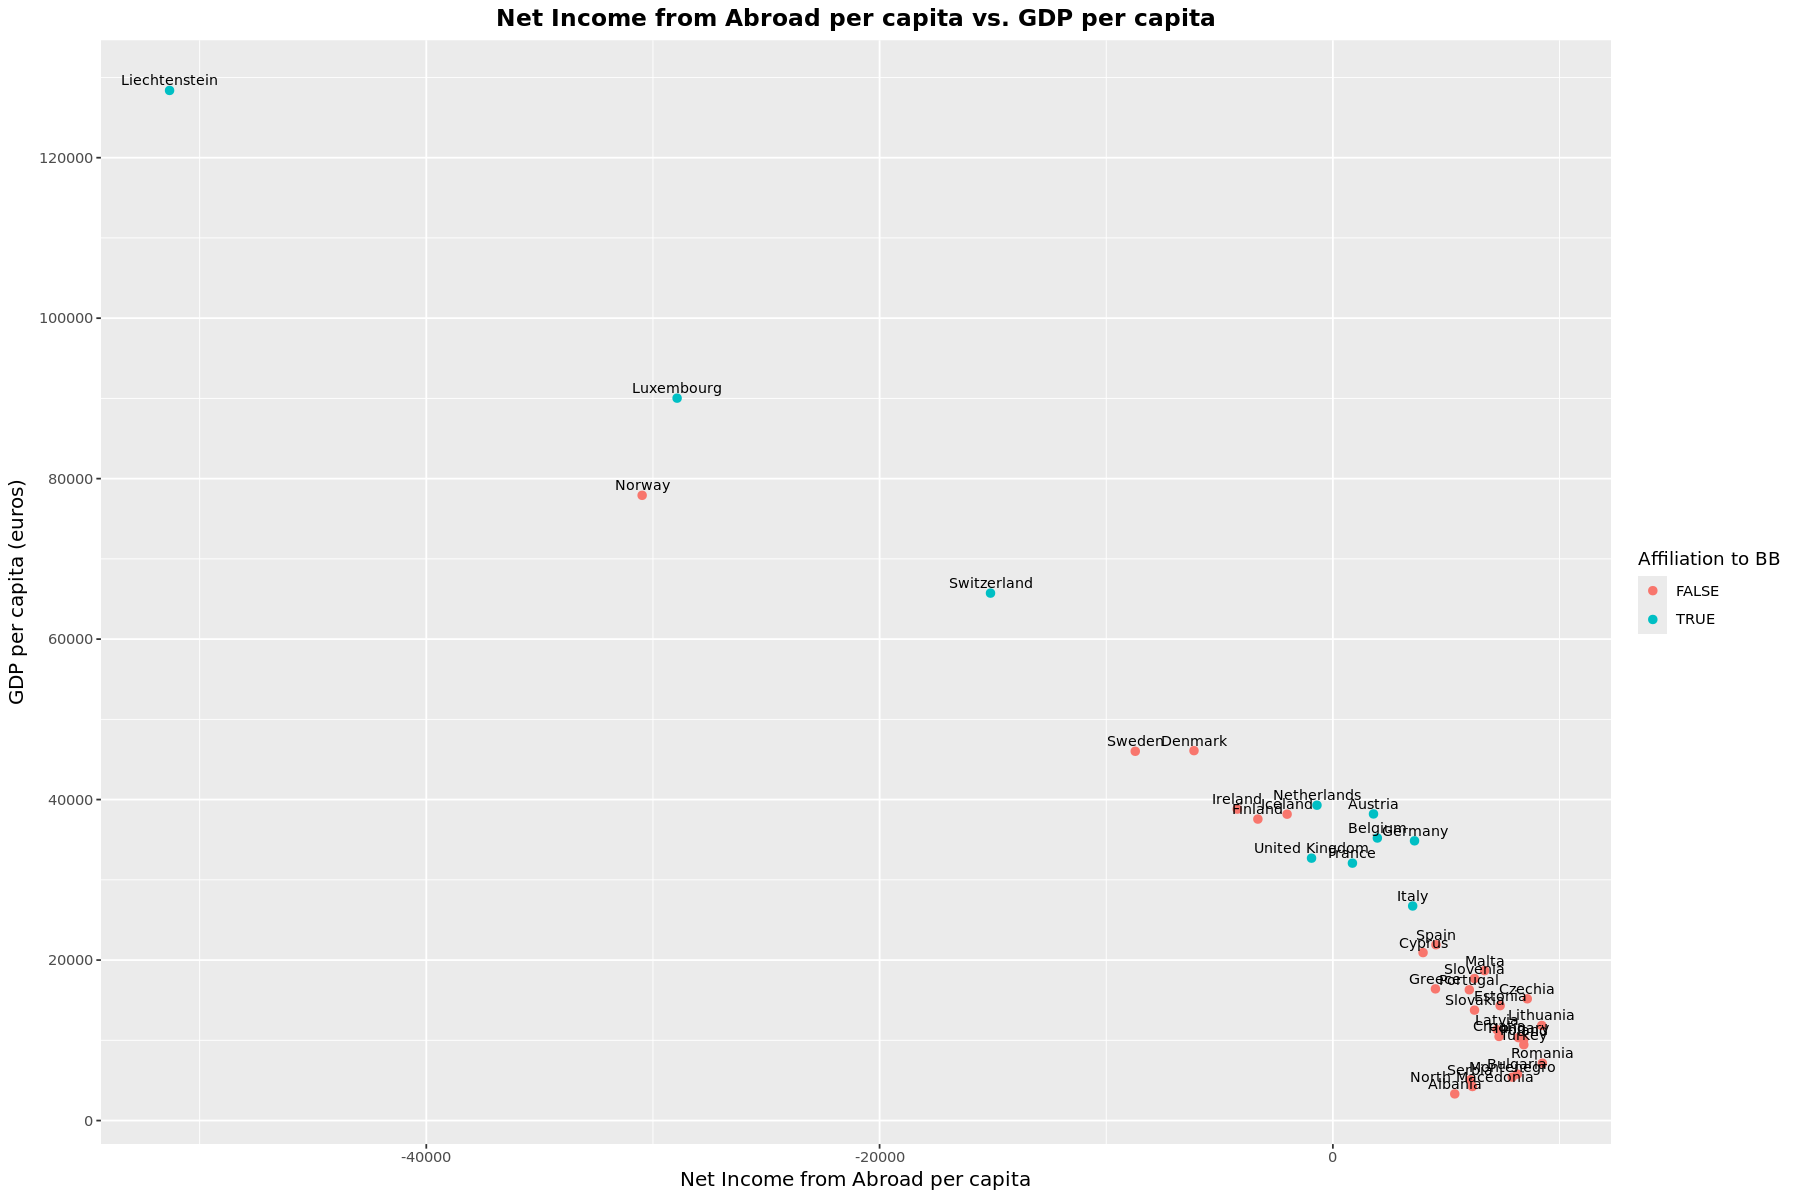

In [117]:
options(repr.plot.width=15, repr.plot.height=10)                        # figure settings 

ggplot(data, aes(x=NFIApc, y=GDPpc)) +
  geom_point(aes(col=BB_entry), size=2) +
  geom_text(aes(label=country), size=3, vjust=-0.5, hjust=0.5) +  
  labs(title='Net Income from Abroad per capita vs. GDP per capita',   # labels
       x='Net Income from Abroad per capita',
       y='GDP per capita (euros)',
       color='Affiliation to BB') + 
  scale_y_continuous(breaks=scales::pretty_breaks(n=5)) +            # set y axis ticks
  theme(
    plot.title = element_text(hjust = 0.5, size=14, face="bold"),      # center and style the title
    axis.title = element_text(size=12),                                # axis title size
  )

- Liechtenstein, Luxembourg, and Norway are notable outliers with high GDP per capita despite negative or zero Net Income from Abroad per capita.
- Most countries cluster around lower GDP per capita values and with low positive Net Income from Abroad per capita.
- The majority of countries have positive Net Income from Abroad per capita, but there are a lot of countries with negative values, suggesting that they spend more abroad than they receive.

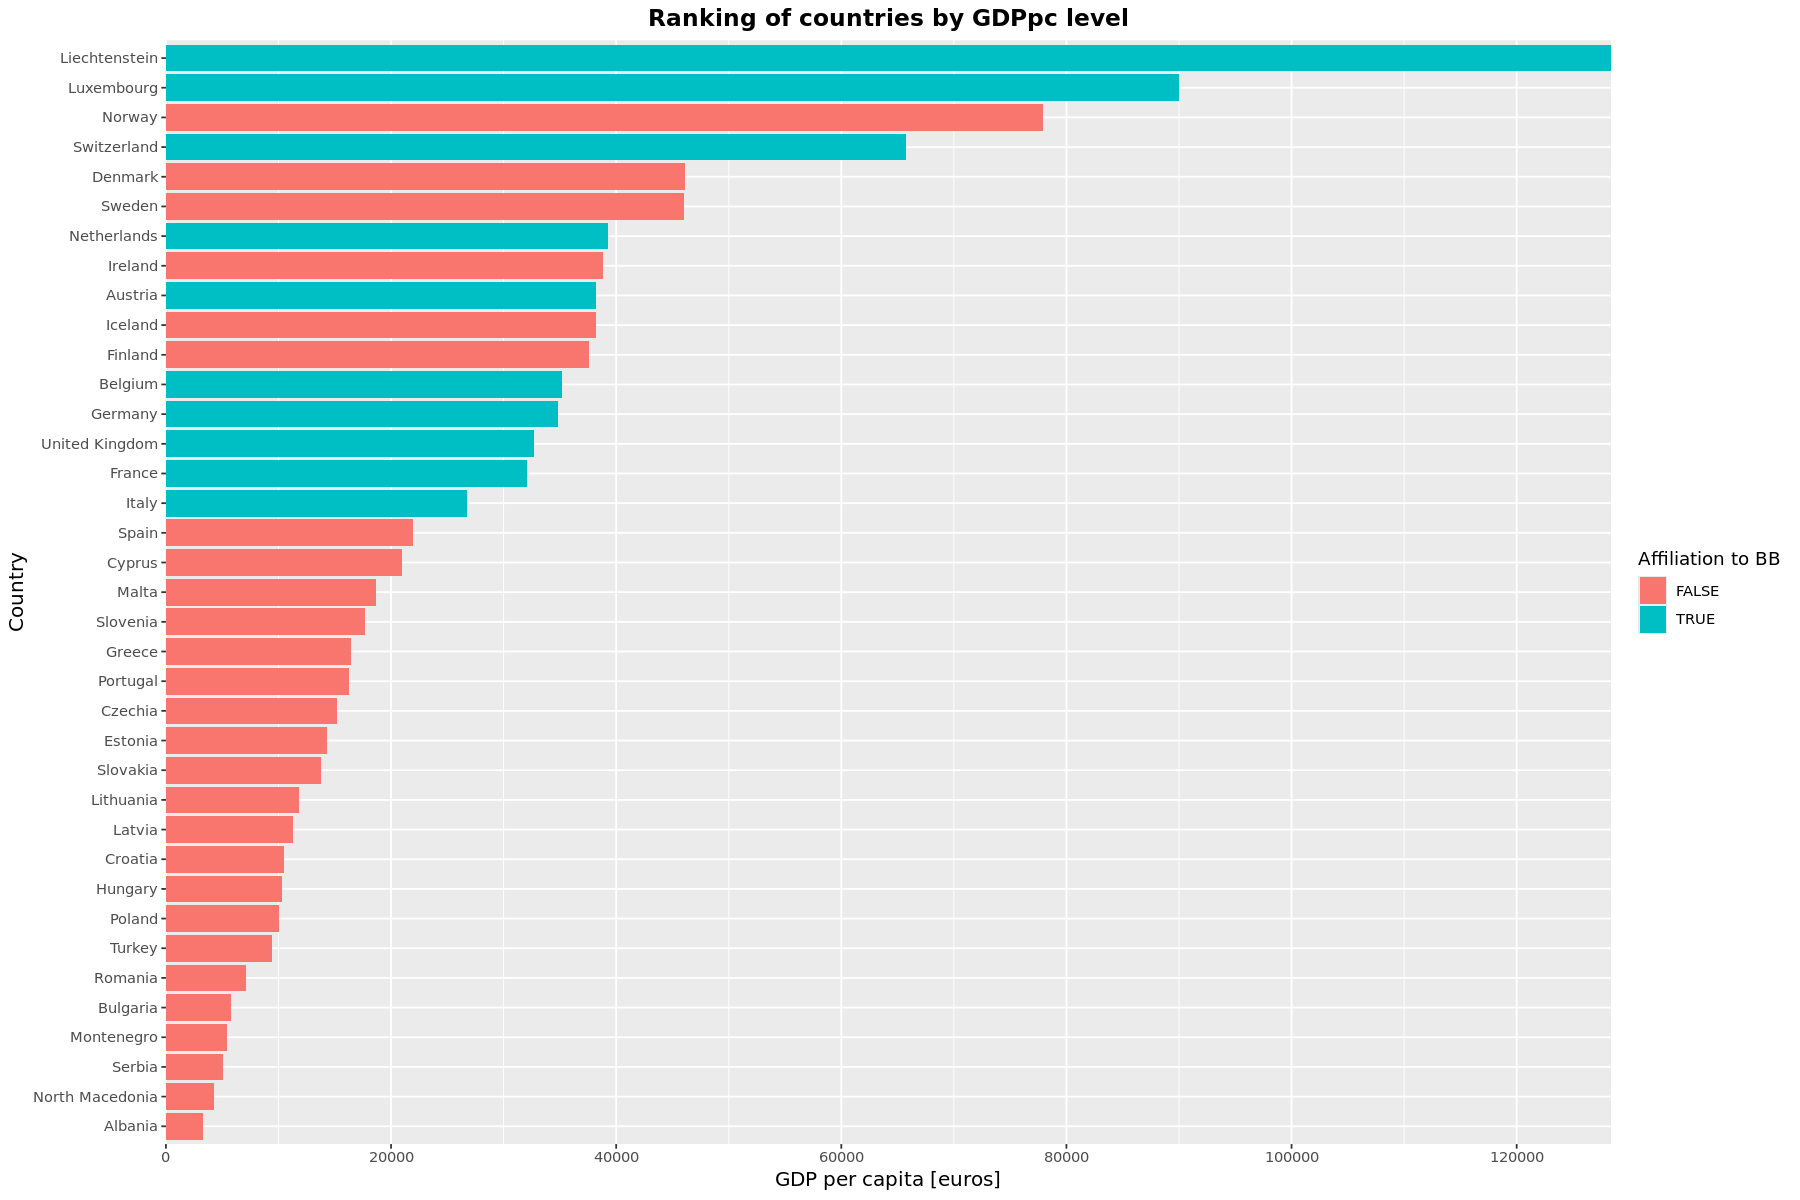

In [118]:
options(repr.plot.width=15, repr.plot.height=10)                        # figure settings 

ggplot(data, aes(x=GDPpc, y=reorder(country, GDPpc), fill=BB_entry)) +
  geom_bar(stat='identity') +
  labs(title='Ranking of countries by GDPpc level',
       x='GDP per capita [euros]',
       y='Country',
       fill='Affiliation to BB') +
  scale_x_continuous(breaks=scales::pretty_breaks(n=6), expand=c(0, 0)) +
  theme(
    plot.title = element_text(hjust = 0.5, size=14, face="bold"),      # center and style the title
    axis.title = element_text(size=12),                                # axis title size
  )

- Top Performers: Liechtenstein, Luxembourg, and Norway are at the top of the list, having the highest GDP per capita.
- Mid-range Performers: Countries like Germany, the United Kingdom, and France are in the middle range, with moderate GDP per capita levels.
- Lower Performers: Countries like Albania, North Macedonia, and Serbia are at the bottom, with the lowest GDP per capita.
- Countries that are listed in BB are placed only in best performing half of the countries presented.

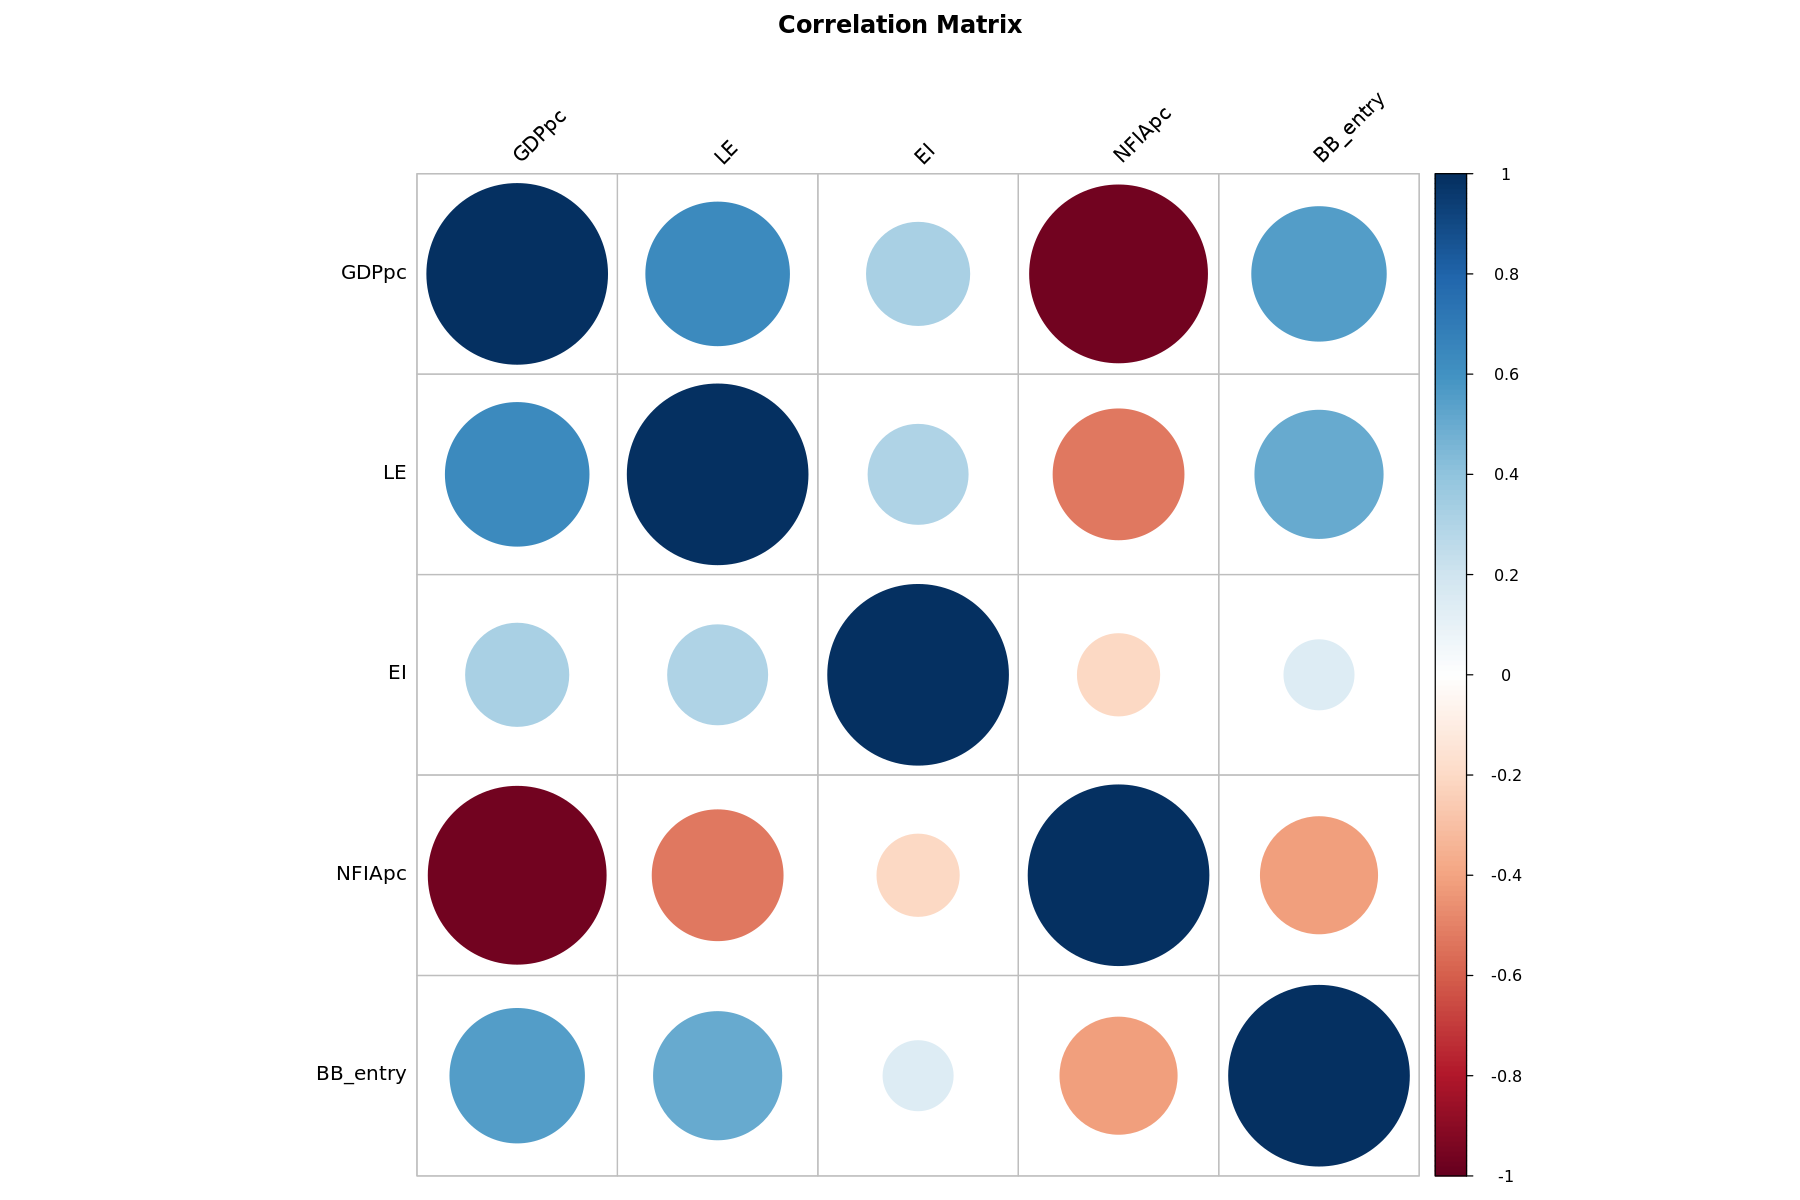

In [119]:
corrplot(cor(data[, -1]), method="circle", 
         tl.col="black", tl.srt=45, 
         title="Correlation Matrix", mar=c(0,0,2,0))

- GDPpc and LE: There is a strong positive correlation between GDP per capita and Life Expectancy, suggesting that higher economic output per person is associated with longer life expectancy.
- NFIapc and GDPpc: There is a strong negative correlation between Net Foreign Income per capita and GDP per capita, suggesting that countries with high GDP per capita tend to have lower net foreign income per capita.
- NFIapc and LE: Similarly, there is a negative correlation between Net Foreign Income per capita and Life Expectancy.

## Tests

In [120]:
# ??????

## Linear model

Simple linear model

In [121]:
model <- lm(GDPpc ~ LE + EI + NFIApc + BB_entry, data = data)
summary(model)


Call:
lm(formula = GDPpc ~ LE + EI + NFIApc + BB_entry, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-10319.6  -1410.4      9.1   2490.5   5288.2 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -7.221e+04  2.215e+04  -3.260 0.002643 ** 
LE            8.396e+02  2.870e+02   2.926 0.006274 ** 
EI            3.810e+04  8.976e+03   4.245 0.000175 ***
NFIApc       -1.746e+00  5.781e-02 -30.213  < 2e-16 ***
BB_entryTRUE  8.246e+03  1.613e+03   5.112 1.43e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3681 on 32 degrees of freedom
Multiple R-squared:  0.9828,	Adjusted R-squared:  0.9807 
F-statistic: 457.6 on 4 and 32 DF,  p-value: < 2.2e-16


**Results interpretation:**
- Intercept: -72210 : predicted value of GDPpc when all independent variables are zero.
- LE (Life Expectancy): 839.6 : for each additional year of life expectancy, GDPpc is expected to increase by 839.6 units
- EI (Education Index): 38100 : for each unit increase in the education index, GDPpc is expected to increase by 38100 units
- NFIApc (Net Foreign Income per capita): -1.746 : for each unit increase in net foreign income per capita, GDPpc is expected to decrease by 1.746 units
- BB_entryTRUE: 8246 : f BB_entry is TRUE, GDPpc is expected to increase by 8246 units compared to when BB_entry is FALSE.

- Adjusted R-squared: 0.9807 : 98.07% of the variability is explained, suggesting a very good model fit.

**Conclusion:**
The regression analysis shows that all independent variables (LE, EI, NFIapc, and BB_entry) are significant predictors of GDPpc. Life expectancy and education index positively impact GDPpc, while net foreign income per capita has a negative impact. The binary variable BB_entry being true also positively impacts GDPpc. The model is a very good fit for the data.